In [1]:
import numpy as np
from sklearn.linear_model import LinearRegression
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('default')
sns.set_palette("colorblind")
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.weight'] = 'light'
rcParams['mathtext.fontset'] = 'cm'
rcParams['mathtext.rm'] = 'serif'
mpl.rcParams["figure.dpi"] = 500
import cartopy.crs as ccrs
import cartopy as ct
import matplotlib.colors as c
import regionmask
import cmasher as cmr
import scipy
from cartopy.util import add_cyclic_point
mpl.rcParams['hatch.linewidth'] = 0.375
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from geocat.comp import eofunc_eofs, eofunc_pcs
from datetime import datetime
import warnings
from matplotlib.patches import Rectangle
import pdo_functions
import importlib
importlib.reload(pdo_functions)
import random
import numba
import statsmodels.api as sm

In [2]:
# Open CAPE data
cape_1940s = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_cape/ERA5_cape/1940s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19400101-19491231.nc')['CAPE'][184*10:]
cape_1950s = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_cape/ERA5_cape/1950s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19500101-19591231.nc')['CAPE'][184*10:]
cape_1960s = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_cape/ERA5_cape/1960s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19600101-19691231.nc')['CAPE'][184*10:]
cape_1970s = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_cape/ERA5_cape/1970s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19700101-19791231.nc')['CAPE'][184*10:]
cape_1980s = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_cape/ERA5_cape/1980s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19800101-19891231.nc')['CAPE']
cape_1990s = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_cape/ERA5_cape/1990s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.19900101-19991231.nc')['CAPE']
cape_2000s = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_cape/ERA5_cape/2000s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.20000101-20091231.nc')['CAPE']
cape_2010s = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_cape/ERA5_cape/2010s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.20100101-20191231.nc')['CAPE']
cape_2020s = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/ERA5_cape/ERA5_cape/2020s/daily_max/e5.oper.an.sfc.128_059_cape.daily_max.20200101-20241130.nc')['CAPE']

In [3]:
# Select the CONUS only
cape_1940s_conus = cape_1940s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_1950s_conus = cape_1950s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_1960s_conus = cape_1960s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_1970s_conus = cape_1970s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_1980s_conus = cape_1980s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_1990s_conus = cape_1990s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_2000s_conus = cape_2000s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_2010s_conus = cape_2010s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))
cape_2020s_conus = cape_2020s.sel(longitude=slice(pdo_functions.convert_longitudes(-125), pdo_functions.convert_longitudes(-66))).sel(latitude=slice(49, 24))

In [4]:
# Concatenate time periods
cape_conus = xr.concat([cape_1940s_conus, cape_1950s_conus, cape_1960s_conus, cape_1970s_conus, cape_1980s_conus, \
                        cape_1990s_conus, cape_2000s_conus, cape_2010s_conus, cape_2020s_conus], dim='time')

In [5]:
# Select MAM and resample to monthly means
cape_conus_mam = cape_conus.sel(time=cape_conus.time.dt.month.isin([3, 4, 5])).resample(time='1Y').mean().dropna(dim='time')

/scratch/ivyglade/miniconda3/envs/myenv_py39/lib/python3.9/site-packages/xarray/groupers.py:326: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  self.index_grouper = pd.Grouper(


In [6]:
# Open SST data and compute the PDO and Nino3.4
sst = xr.open_dataset('/hurrell-scratch2/ivyglade/pdo/HadISST_sst.nc')['sst']

pdo = pdo_functions.pdo_from_hadisst(sst, 1980, 2010)

nino_34 = pdo_functions.calc_nino_34_timeseries(sst, False, 1980, 2010)

In [7]:
# Standardize Nino3.4
nino_34_std = (nino_34 - nino_34.mean()) / nino_34.std()

In [8]:
# Convert pdo to xarray
pdo_xr = xr.DataArray(pdo, coords={'time':nino_34['time']}, dims=['time'])

# Subset only 1940-2024
pdo_1940_2024 = pdo_xr.sel(time=pdo_xr.time.dt.year.isin(np.arange(1940, 2025, 1)))
nino_34_1940_2024 = nino_34_std.sel(time=nino_34_std.time.dt.year.isin(np.arange(1940, 2025, 1)))

# only MAM
pdo_1940_2024_mam = pdo_1940_2024.sel(time=pdo_1940_2024.time.dt.month.isin([3, 4, 5])).groupby('time.year').mean()
nino_34_1940_2024_mam = nino_34_1940_2024.sel(time=nino_34_1940_2024.time.dt.month.isin([3, 4, 5])).groupby('time.year').mean()

In [9]:
def detrend_dim(da, dim, deg):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

In [10]:
# degree 2 polynomial detrend
cape_conus_mam_detrend = detrend_dim(cape_conus_mam, 'time', 2)

In [11]:
# Subset an eastern US region
cape_conus_mam_anoms_east = cape_conus_mam_detrend.sel(longitude=slice(pdo_functions.convert_longitudes(-101), pdo_functions.convert_longitudes(-83))).sel(latitude=slice(47, 31))

In [12]:
weights = np.cos(np.deg2rad(cape_conus_mam_anoms_east.latitude))

cape_conus_mam_east_anoms = cape_conus_mam_anoms_east.weighted(weights).mean(dim=('latitude', 'longitude'))

In [18]:
window_weights = np.array([1, 3, 5, 3, 1])
window_weights = window_weights / window_weights.sum()

In [19]:
rolling_mean = cape_conus_mam_east_anoms.rolling(time=5, center=True).mean()
rolling_135_mean = cape_conus_mam_east_anoms.rolling(time=5, center=True).construct('window').dot(xr.DataArray(window_weights, dims='window'))

In [20]:
rolling_mean_corr = np.corrcoef(rolling_mean[2:-2], pdo_1940_2024_mam[2:-2])[0, 1]
rolling_135_mean_corr = np.corrcoef(rolling_135_mean[2:-2], pdo_1940_2024_mam[2:-2])[0, 1]
no_filter_corr = np.corrcoef(cape_conus_mam_east_anoms, pdo_1940_2024_mam)[0, 1]

Text(0.5, 1.0, '1-3-5-3-1 filter')

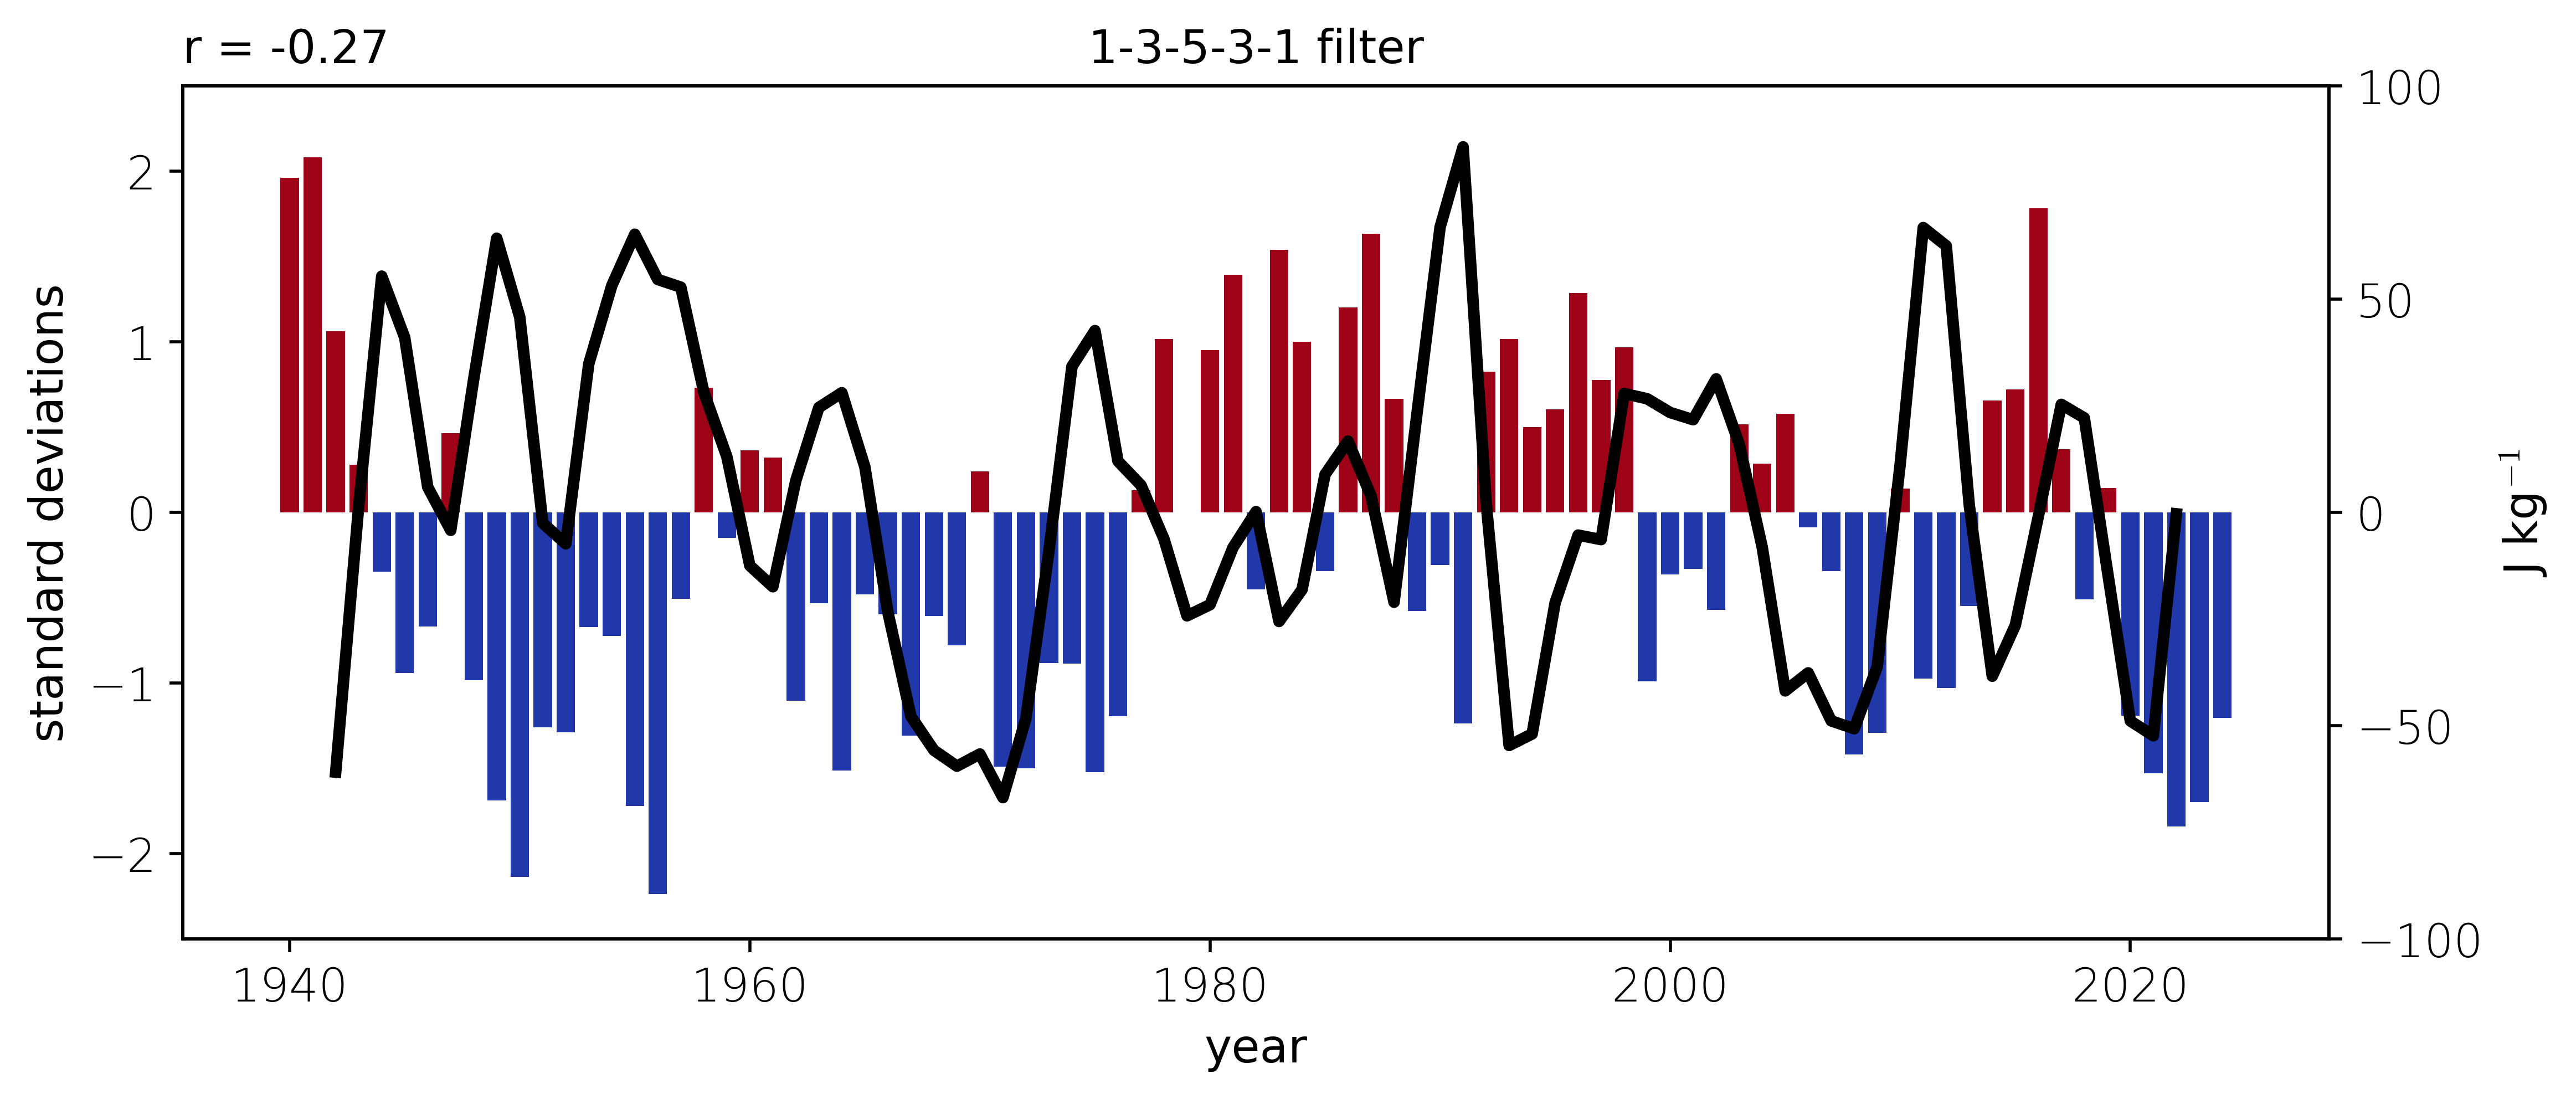

In [26]:
fig, ax = plt.subplots(figsize=(10, 4))

years = np.arange(1940, 2025, 1)

ax.bar(years[pdo_1940_2024_mam > 0], pdo_1940_2024_mam[pdo_1940_2024_mam > 0], color='xkcd:carmine')
ax.bar(years[pdo_1940_2024_mam < 0], pdo_1940_2024_mam[pdo_1940_2024_mam < 0], color='xkcd:sapphire')
ax.set_ylim(-2.5, 2.5)

ax2 = ax.twinx()
# ax2.plot(cape_conus_mam_east_anoms)
# ax2.plot(years, cape_conus_mam_east_anoms, color='black', lw=3)
ax2.plot(years, rolling_135_mean, color='black', lw=3)
ax2.set_ylim(-100, 100)

ax.set_title(f'r = {rolling_135_mean_corr:.2f}', loc='left')

ax.set_ylabel('standard deviations', fontsize=12)
ax2.set_ylabel('J kg$^{-1}$', fontsize=12)
ax.set_xlabel('year', fontsize=12)
ax.tick_params(labelsize=12)
ax2.tick_params(labelsize=12)
ax2.set_yticks([-100, -50, 0, 50, 100])

ax.set_title('1-3-5-3-1 filter', fontsize=12)